In [18]:
# %% codecell
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from mil_functions import get_dws_from,moving_average,inject_anomaly,next_step_splitter,plot_anomaly_detection

raw_samples = pickle.load(open("Data/raw_dws.pkl", "rb"))

avg_samples = pickle.load(open("Data/dw_normal_averaged.pkl", "rb"))



#these are anomalies added manually at a single point, however they are unrealsitic since they go beyond a bit flip
#inject anomalies into raw samples (then take moving average)
anomaly_samples_avg = []
injection_settings = ((((np.arange(2000,4000),np.random.ranf(2000)*1))), ) * 60


for idx,samples in enumerate(raw_samples):
    anomaly_samples_avg.append(inject_anomaly(samples,*injection_settings[idx]))



raw_samples_norm = list(map(lambda samples: (samples - np.min(samples))/(np.max(samples)- np.min(samples)+1), raw_samples))






import tensorflow

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#choose model for unsupervised anomaly detection
model = pickle.load(open("Data/cnn_model_pred2.pkl", "rb"))

/home/aviraj/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [19]:
len(raw_samples)

select_idx = 0

for window in [1000]:
    anomaly_peaks = []

    for select_idx in range(60):

        # anomaly types, these are more realistic to an actual bitflip

        # random flips 1, 2, 3 bits
        single_bitflip = 2 ** np.arange(16)
        random_single_flips = np.array(list(map(lambda x:  np.bitwise_xor(x, np.random.choice(single_bitflip)),raw_samples[select_idx])))
        random_double_flips = np.array(list(map(lambda x:  np.bitwise_xor(x, np.random.choice(single_bitflip)),random_single_flips)))
        random_triple_flips = np.array(list(map(lambda x:  np.bitwise_xor(x, np.random.choice(single_bitflip)),random_double_flips)))
        # flip lower
        single_bitflip = 2 ** np.arange(0,8)
        lower_flips = np.array(list(map(lambda x:  np.bitwise_xor(x, np.random.choice(single_bitflip)),raw_samples[select_idx])))
        # flip higher bits
        single_bitflip = 2 ** np.arange(8,16)
        higher_bitflips = np.array(list(map(lambda x:  np.bitwise_xor(x, np.random.choice(single_bitflip)),raw_samples[select_idx])))


        og_raw = moving_average(raw_samples[select_idx],window)
        random_single_flips = moving_average(random_single_flips,window)
        random_double_flips = moving_average(random_double_flips,window)
        random_triple_flips = moving_average(random_triple_flips,window)
        lower_flips = moving_average(lower_flips,window)
        higher_bitflips = moving_average(higher_bitflips, window)

        injection_locations = np.array([np.array_split(np.arange(15000),10)[::2]]).flatten()

        baseline_locations = np.array(np.array_split(np.arange(15000),10)[1::2]).flatten()

        random_single_flips.shape
        og_raw.shape
        # put original raw values into anomaly values

        np.put(random_single_flips, injection_locations, og_raw[injection_locations])
        np.put(random_double_flips, injection_locations, og_raw[injection_locations])
        np.put(random_triple_flips, injection_locations, og_raw[injection_locations])
        np.put(lower_flips, injection_locations, og_raw[injection_locations])
        np.put(higher_bitflips, injection_locations, og_raw[injection_locations])

        #normalize and movingg average all



        anomaly_samples_avg = [ moving_average(raw_samples[select_idx],window),
                                random_single_flips,
                                random_double_flips,
                                random_triple_flips,
                                lower_flips,
                                higher_bitflips]

        #normalizing after anomalies added
        anomaly_samples_avg = list(map(lambda samples: (samples - np.min(samples))/(np.max(samples)- np.min(samples)+1), anomaly_samples_avg))
        # anomaly_samples_avg = list(map(lambda samples: (samples - np.min(samples))/(np.max(samples)- np.min(samples)+1), anomaly_samples_avg))




        #norm
        # #normalize after adding anomaly
        raw_samples_norm = list(map(lambda samples: (samples - np.min(samples))/(np.max(samples)- np.min(samples)+1), raw_samples))
        #
        #
        # #create sequences for prediction task
        anomaly_avg_sequences = []
        for sample in anomaly_samples_avg:
            sample_anomaly_avg_sequences, _ = next_step_splitter(sample[:-1], width=100, prediction_size=2)
            sample_anomaly_avg_sequences = np.expand_dims(sample_anomaly_avg_sequences,axis=2)
            anomaly_avg_sequences.append(sample_anomaly_avg_sequences)

        #
        # pickle.dump(anomaly_avg_sequences, open("Data/dw_anomaly_averaged_sequences.pkl", "wb"))
        # anomaly_avg_sequences = pickle.load(open("Data/dw_anomaly_averaged_sequences.pkl", "rb"))


        baseline = moving_average(raw_samples_norm[select_idx],window)
        # plt.plot(baseline)

        # predictions  = model.predict(anomaly_avg_sequences[select_idx])
        # plt.plot(abs(baseline[np.mod(np.arange(baseline.size),152)!=0] - predictions.flatten()))

        titles = [ "Baseline",
                    "Random Single Flips",
                    "Random Double Flips",
                    "Random Triple Flips",
                    "Lower Flips",
                    "Higher Bitflips"]


        for i in range(1,4):
            try:
                baseline = moving_average(raw_samples_norm[select_idx],window)
                predictions  = model.predict(anomaly_avg_sequences[i])
                predictions = predictions.flatten()
                # plt.figure()
                # plt.title(f'Baseline')
                # plt.plot(baseline)
                # plt.xlabel("Packet Arrivals Over Time")
                # plt.ylabel("Raw Normalized Integer")
                # # plt.plot(predictions)
                # plt.figure()
                # plt.title(f'Next Value Prediction Error for {titles[i]}')
                #
                # plt.xlabel("Packet Arrivals Over Time")
                # plt.ylabel("Prediction Error")
                # plt.axhline(y=0.12, color='r', linestyle='-')
                next_val_err = abs(baseline[np.mod(np.arange(baseline.size),152)!=0] - predictions.flatten())
                # plt.plot(next_val_err)

                anomaly_peaks.append(next_val_err)
                print(titles[i], np.average(next_val_err))
                # plt.figure()
            except:
                continue
                
pickle.dump(anomaly_peaks, open("Data/anomaly_peaks.pkl", "wb"))

Random Single Flips 0.4665068777643233
Random Double Flips 0.48978485887029355
Random Triple Flips 0.4942490009891994
Random Single Flips 0.08181596172884116
Random Double Flips 0.11942160120192609
Random Triple Flips 0.14725782526513448
Random Single Flips 0.08799263649797126
Random Double Flips 0.12433813953890044
Random Triple Flips 0.1550064583599566
Random Single Flips 0.27566317984920263
Random Double Flips 0.3233109402484936
Random Triple Flips 0.3423725074920597
Random Single Flips 0.14560289227492235
Random Double Flips 0.25357620587664087
Random Triple Flips 0.2839325398849133
Random Single Flips 0.23366919977900638
Random Double Flips 0.29775703180546664
Random Triple Flips 0.3342737737020461
Random Single Flips 0.06911463286829851
Random Double Flips 0.0999586256325621
Random Triple Flips 0.13735540202414537
Random Single Flips 0.18134810223683367
Random Double Flips 0.2590165772270357
Random Triple Flips 0.3091208995361969
Random Single Flips 0.1918054721610612
Random Doub

In [20]:

anomaly_peaks = pickle.load(open("Data/anomaly_peaks.pkl", "rb"))

/home/aviraj/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


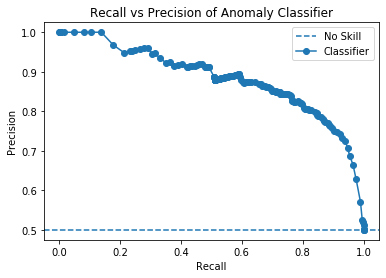

In [21]:
#
#
anomaly_counts = []

len(anomaly_peaks)
for i in range(len(anomaly_peaks)):
    peaks, information = find_peaks(anomaly_peaks[i], prominence=1)
    anomaly_counts.append(information["prominences"].shape[0])



anomaly_counts = np.array(anomaly_counts)

anomaly_counts[anomaly_counts > 10] = 10




pr = []
np.arange(0.005, 0.4,0.005)

for prom in np.arange(0.005, 1,0.005):
    anomaly_counts = []

    for i in range(len(anomaly_peaks)):
        peaks, information = find_peaks(anomaly_peaks[i], prominence=prom)
        anomaly_counts.append(information["prominences"].shape[0])



    anomaly_counts = np.array(anomaly_counts)
    anomaly_counts[anomaly_counts > 10] = 10



    subset = anomaly_counts[(-10<anomaly_counts) & (anomaly_counts<=10)]
    fn= tp = fp = 0
    for count in subset:
        count = count - 5
        if(count>=0):
            tp += 5
            fp += count
        else:
            tp += 5 + count
            fn += np.abs(count)


    p = tp / (tp + fp)
    r = tp / (tp + fn)
    pr.append([p,r])



p_list = np.array(pr)[:,0]
r_list = np.array(pr)[:,1]



plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs Precision of Anomaly Classifier')
plt.axhline(y=0.5,linestyle='--',label='No Skill')
plt.plot(r_list,p_list,'-o',label='Classifier')
plt.legend()

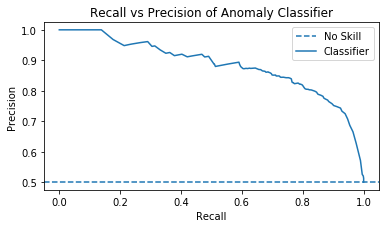

In [22]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Recall vs Precision of Anomaly Classifier')
plt.axhline(y=0.5,linestyle='--',label='No Skill')
plt.plot(r_list,p_list,'-',label='Classifier')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')

In [23]:
import seaborn as sns



ax = sns.histplot(data=anomaly_counts[0],kde=True, binwidth=1)
ax.set(title="Total Anomaly Detections after 5 Anomalies Injected",
    ylabel='Number of Samples',
    xlabel='Anomalies Predicted in after 5 Anomaly Injections', xlim=(0,15))
ax.axvline(5)

TypeError: object of type 'numpy.int64' has no len()

In [ ]:
np.array_split(np.arange(15000),10)[::2]

plt.plot(anomaly_peaks[20])
len(anomaly_peaks)

widths = []

for i in range(len(anomaly_peaks)):
    peaks, information = find_peaks(anomaly_peaks[i], width=10,prominence=.45)
    widths.append(np.abs((information["widths"] - 1500)/2))



all_widths = np.concatenate(widths).flatten()

all_widths

import seaborn as sns
ax = sns.histplot(data=all_widths,kde=True, binwidth=1)
ax.set(title="Distribution of Total Packet Occurences before Anomaly Detection",
    ylabel='Number of Samples',
    xlabel='Packet occurences before Anomaly Detection',xlim=(0,50))


peaks, information = find_peaks(anomaly_peaks[20], prominence=.45)
information["prominences"].shape

In [ ]:
widths = []

for i in range(len(anomaly_peaks)):
    peaks, information = find_peaks(anomaly_peaks[i], prominence=.15)
    widths.append(information["prominences"].shape[0])





widths

import seaborn as sns


ax = sns.histplot(data=widths,kde=True, binwidth=1)
ax.set(title="Total Anomaly Detections after 5 Anomalies Injected",
    ylabel='Number of Samples',
    xlabel='Anomalies Predicted in after 5 Anomaly Injections', xlim=(0,15))
ax.axvline(5)